# Fashion MNIST and MNIST Classfication
Author: Siddharth Betala

### Import Necessary Libraries

In [1]:
from copy import deepcopy
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

### Template Classes

In [2]:
class AutoDiffFunction():
    """Format for any function in general which has to be auto-differentiable
    """

    def __init__(self, *args, **kwds) -> None:
        self.saved_for_backward = {} # caching to save computation
        self.grad = {} # holds gradients

    def __call__(self, *args, **kwds):
        
        # performs one forward and backward pass in each call
        output = self.forward(*args, **kwds)
        self.grad = self.compute_grad(*args, **kwds)
        return output

    def forward(self, *args, **kwds):
        """Calculates a forward pass
        """
        pass

    def compute_grad(self, *args, **kwds):
        """Computes local gradient of that function itself w.r.t its input
        """
        pass

    def backward(self, *args, **kwds):
        """Computes actual gradient w.r.t. the loss after chained gradients ahead 
            of the function till the loss are passed 
        """
        pass


class Layer(AutoDiffFunction):
    """Format to create your own custom layer for the model
    """
    def __init__(self, *args, **kwds) -> None:
        super().__init__(*args, **kwds)

        self.weights = {} # holds weights of the layer
        self.optimizer = None # optimizer for the layer

    def initialize_weights(self, *args, **kwds):
        """Initialize weights for the layer
        """
        pass

    def update_weights(self):
        """Updates weights of the layer using layer's assigned optimizer
        """
        self.optimizer.step(self)


class Loss(AutoDiffFunction):
    """Format to create a custom loss function
    """

    def forward(self, y_true, y_pred):
        """Calculates a forward pass
        """
        pass 

    def backward(self):
        """Computes actual gradient w.r.t. the loss after chained gradients ahead 
            of the function till the loss are passed 
        """
        return self.grad["x"]

    def compute_grad(self, y_true, y_pred):
        """Computes local gradient of that function itself w.r.t its input
        """
        pass


class Optimizer():
    """Format to create a custom optimizer
    """
    def __init__(self, *args, **kwds):
        self.remember = {} # remembering parameters from last iteration
        pass

    def step(self, layer):
        """Performs the update step for weights of the optmizer

        Args:
            layer: Layer object assigned to the optimizer 
        """
        pass    

### Activation Functions

In [3]:
class Sigmoid(AutoDiffFunction):
    """ 
    Represents the Sigmoid Activation function
    """
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x):
        self.saved_for_backward = 1/(1 + np.exp(-x))
        return self.saved_for_backward

    def compute_grad(self, x):
        y = self.saved_for_backward

        return {"x": y*(1-y)}

    def backward(self, dy):
        return dy * self.grad["x"]      


class RelU(AutoDiffFunction):
    """ 
    Represents the RelU Activation function
    """
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x):
        self.saved_for_backward = np.where(x>0.0, 1.0, 0.0)

        return x * self.saved_for_backward

    def compute_grad(self, x):
        return {"x": self.saved_for_backward}

    def backward(self, dy):
        return dy * self.grad["x"]
    
class Tanh(AutoDiffFunction):
    """ 
    Represents the Tanh Activation function
    """
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x):
        self.saved_for_backward = (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

        return self.saved_for_backward

    def compute_grad(self, x):
        y = self.saved_for_backward

        return {"x": 1 - y**2}

    def backward(self, dy):
        return dy * self.grad["x"]

### Fully-connected Layers

In [4]:
class FC(Layer):
    def __init__(self, in_dim, out_dim, weight_decay=None, init_method="random") -> None:
        super().__init__()
        self.weight_decay = weight_decay
        self.init_method = init_method
        self.initialize_weights(in_dim, out_dim)

    def initialize_weights(self, in_dim, out_dim):
        
        if self.init_method == "random":
            scaling_factor = 1/np.sqrt(in_dim)
            self.weights["w"] = np.random.randn(in_dim, out_dim) * scaling_factor
            self.weights["b"] = np.random.randn(1, out_dim) * scaling_factor
        elif self.init_method == "xavier":
            lim = np.sqrt(6 / (in_dim + out_dim))
            self.weights["w"] = np.random.uniform(low=-lim, high=lim, size=(in_dim, out_dim))
            self.weights["b"] = np.random.uniform(low=-lim, high=lim, size=(1, out_dim))

    def compute_grad(self, x):
        
        gradients = {}

        # y = x * w + b        
        # we compute gradients wrt w and x 
        # gradient wrt b is not required explicitly since we know that it's value is 1
        gradients["w"] = self.saved_for_backward["x"].T
        gradients["x"] = self.weights["w"].T

        return gradients


    def forward(self, x):
        output = x @ self.weights["w"] + self.weights["b"]
        self.saved_for_backward["x"] = x
        
        return output

    def backward(self, dy):
        
        # calculating gradients wrt input to pass on to previous layer for backprop
        dx = dy @ self.grad["x"]
        
        # calculating gradients wrt weights
        dw = self.grad["w"] @ dy
        db = np.sum(dy, axis=0, keepdims=True)

        # accomodating for weight_decay / L2 regularization
        if self.weight_decay:
            dw = dw + 2 * self.weight_decay * self.weights["w"]
            db = db + 2 * self.weight_decay * self.weights["b"]

        self.absolute_gradients = {"w": dw, "b": db}

        return dx

    def update_weights(self):
        self.optimizer.step(self)

### Loss Functions

In [5]:
# 1. CROSSENTROPY LOSS
class CrossEntropyLossFromLogits(Loss):
    def __init__(self) -> None:
        super().__init__()
        self.n_classes = None

    @staticmethod
    def softmax(x):
        v = np.exp(x)
        return v / np.sum(v, axis=1, keepdims=True)

    def encode(self, y): 
        encoded_y = np.zeros(shape=(len(y), self.n_classes))

        for i in range(len(y)):
            encoded_y[i,y[i]] = 1

        return encoded_y

    def forward(self, y_pred, y_true):
         
        probabilities = self.softmax(y_pred)
        y_true_encoded = self.encode(y_true)

        loss_value = np.mean(np.sum(- y_true_encoded * np.log(probabilities), axis=1))

        self.saved_for_backward["probabilities"] = probabilities
        self.saved_for_backward["y_true"] = y_true_encoded

        return loss_value

    def compute_grad(self, y_pred, y_true):

        return {"x": self.saved_for_backward["probabilities"] - self.saved_for_backward["y_true"]}        


# 2. MEAN SQUARED LOSS
class MSELossFromLogits(Loss):
    def __init__(self) -> None:
        super().__init__()
        self.n_classes = None

    @staticmethod
    def softmax(x):
        v = np.exp(x)

        return v / np.sum(v, axis=1, keepdims=True)

    def encode(self, y): 
        encoded_y = np.zeros(shape=(len(y), self.n_classes))

        for i in range(len(y)):
            encoded_y[i,y[i]] = 1

        return encoded_y
    
    @staticmethod
    def indicator(i, j):
        ind = {True: 1, False: 0}
        return ind[i==j]

    def forward(self, y_pred, y_true):
         
        probabilities = self.softmax(y_pred)
        y_true_encoded = self.encode(y_true)

        loss_value = np.mean(np.sum((probabilities - y_true_encoded)**2, axis=1))

        self.saved_for_backward["probabilities"] = probabilities
        self.saved_for_backward["y_true"] = y_true_encoded

        return loss_value

    def compute_grad(self, y_pred, y_true):

        probs = self.saved_for_backward["probabilities"]
        labels = self.saved_for_backward["y_true"]
        grad = np.zeros(shape=(len(y_true), self.n_classes))
        
        for point_counter in range(len(y_true)):
            res = 0
            for i in range(self.n_classes):
                for j in range(self.n_classes):
                    
                    res = probs[point_counter, j] * (probs[point_counter, j] - labels[point_counter, j]) * (self.indicator(i,j) - probs[point_counter, i])
                
                grad[point_counter, i] = res
        
        return {"x": grad}

### Optimizers

In [6]:
# 1. SGD OPTIMIZER
class SGD(Optimizer):
    def __init__(self, lr=1e-2):
        super().__init__()
        self.lr = lr

    def step(self, layer):

        for weight_name, _ in layer.weights.items():
            layer.weights[weight_name] = layer.weights[weight_name] - self.lr * layer.absolute_gradients[weight_name]
            

# 2. MOMENTUM OPTIMIZER
class Momentum(Optimizer):
    def __init__(self, lr=1e-3, gamma=0.9):
        super().__init__()
        self.lr = lr
        self.gamma = gamma
        
    def step(self, layer):
        
        #Initialise update history
        if self.remember == {}:
            for weight_name, weight in layer.weights.items():
                self.remember[weight_name] = {}
                self.remember[weight_name]["v"] = np.zeros_like(weight)
        
        #Momentum update rule
        for weight_name, weight in layer.weights.items():
            self.remember[weight_name]["v"] = self.gamma * self.remember[weight_name]["v"] + \
                                                self.lr * layer.absolute_gradients[weight_name]
            layer.weights[weight_name] = layer.weights[weight_name] - self.remember[weight_name]["v"]

            
# 3. NESTEROV ACCELARATED GRADIENT OPTIMIZER
class NAG(Optimizer):
    def __init__(self, lr=1e-3, gamma=0.9):
        super().__init__()
        self.lr = lr
        self.gamma = gamma 

    def step(self, layer):

        if self.remember == {}:
            for weight_name, weight in layer.weights.items():
                self.remember[weight_name] = {}
                self.remember[weight_name]["v"] = np.zeros_like(weight)

        for weight_name, weight in layer.weights.items():
            layer.weights[weight_name] = layer.weights[weight_name] + (self.gamma**2) * self.remember[weight_name]["v"] - \
                                            (1 + self.gamma) * self.lr * layer.absolute_gradients[weight_name]

            self.remember[weight_name]["v"] = self.remember[weight_name]["v"] * self.gamma - \
                                                self.lr * layer.absolute_gradients[weight_name]

# 4. RMSPROP OPTIMIZER
class RMSprop(Optimizer):
    def __init__(self, lr=1e-3, beta=0.9, epsilon=1e-7):
        super().__init__()
        self.lr = lr
        self.beta = beta
        self.epsilon = epsilon
        
    def step(self, layer):
        
        #Initialise update history
        if self.remember == {}:
            for weight_name, weight in layer.weights.items():
                self.remember[weight_name] = {}
                self.remember[weight_name]["v"] = np.zeros_like(weight)
        
        #RMSprop update rule
        for weight_name, weight in layer.weights.items():
            self.remember[weight_name]["v"] = self.beta * self.remember[weight_name]["v"] + \
                                                (1 - self.beta) * (layer.absolute_gradients[weight_name] ** 2)
            layer.weights[weight_name] = layer.weights[weight_name] - (self.lr / (np.sqrt(self.remember[weight_name]["v"] + \
                                                self.epsilon))) * layer.weights[weight_name]

            
# 5. ADAM OPTIMIZER
class Adam(Optimizer):
    def __init__(self, lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-7):
        super().__init__()
        self.lr = lr
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.t = 1
        
    def step(self, layer):
        
        #Initialise update history
        if self.remember == {}:
            for weight_name, weight in layer.weights.items():
                self.remember[weight_name] = {}
                self.remember[weight_name]["v"] = np.zeros_like(weight)
                self.remember[weight_name]["m"] = np.zeros_like(weight)
        
        #Adam update rule
        for weight_name, weight in layer.weights.items():
            
            #Update m_t and v_t
            self.remember[weight_name]["m"] = self.beta_1 * self.remember[weight_name]["m"] + \
                                                (1 -self.beta_1) * layer.absolute_gradients[weight_name]
            
            self.remember[weight_name]["v"] = self.beta_2 * self.remember[weight_name]["v"] + \
                                                (1 - self.beta_2) * (layer.absolute_gradients[weight_name]**2)
            
            #Bias correction
            m_hat = self.remember[weight_name]["m"]/(1 - self.beta_1 ** self.t)
            v_hat = self.remember[weight_name]["v"]/(1 - self.beta_2 ** self.t)
            
            #Update parameters
            layer.weights[weight_name] = layer.weights[weight_name] - (self.lr / (np.sqrt(v_hat + self.epsilon))) * m_hat
            
        self.t += 1
            
            
# 6. NADAM OPTIMIZER            
class Nadam(Optimizer):
    def __init__(self, lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-7):
        super().__init__()
        self.lr = lr
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.t = 1

    def step(self, layer):
        
        # we have 2 parameters to remember m(t) and v(t) for all weights in the layer
        if self.remember == {}:
            for weight_name, weight in layer.weights.items():
                self.remember[weight_name] = {}
                self.remember[weight_name]["v"] = np.zeros_like(weight)
                self.remember[weight_name]["m"] = np.zeros_like(weight)

        for weight_name, weight in layer.weights.items():
            
            self.remember[weight_name]["m"] = self.beta_1 * self.remember[weight_name]["m"] + \
                                                (1 -self.beta_1) * layer.absolute_gradients[weight_name]

            self.remember[weight_name]["v"] = self.beta_2 * self.remember[weight_name]["v"] + \
                                                (1 - self.beta_2) * layer.absolute_gradients[weight_name]**2

            # bias correction step 
            m_hat = self.remember[weight_name]["m"]/(1 - self.beta_1 ** self.t)
            v_hat = self.remember[weight_name]["v"]/(1 - self.beta_2 ** self.t)

            d = self.lr / (np.sqrt(v_hat) + self.epsilon) * (self.beta_1*m_hat + (1-self.beta_1)/
                                                (1-self.beta_1 ** self.t) * layer.absolute_gradients[weight_name]) 

            layer.weights[weight_name] = layer.weights[weight_name] - d

        self.t += 1

### Neural Network Framework

In [7]:
class NeuralNet():
    def __init__(self, layers) -> None:
        self.layers = layers
        self.history = []

    def __call__(self, *args, **kwds):
        return self.forward(*args, **kwds)

    def compile(self, loss, optimizer):
        self.loss = loss

        for layer in self.layers:
            if isinstance(layer, Layer):
                layer.optimizer = deepcopy(optimizer) # each layer has it's own optimizer

    def forward(self, x):
        """Performs forward pass for the entire network

        Args:
            x (np.ndarray): input array

        Returns:
            np.ndarray: output of the neural network
        """
        for layer in self.layers:
            x = layer(x)

        return x

    def backward(self):
        """Performs one backward pass for the entire network
            and saves the gradients

        Returns:
            np.ndarray: gradient of the 1st layer
        """

        gradient = self.loss.backward()
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)

        return gradient

    def update_weights(self):
        """Updates weights of all layers using the chosen optimizer 
            and saved gradients
        """

        for layer in reversed(self.layers):
            if isinstance(layer, Layer):
                layer.update_weights()

    @staticmethod
    def accuracy_score(y_pred, y_true):
        """Returns accuracy score

        Args:
            y_pred (np.ndarray): predicted labels (batch_size X n_classes)
            y_true (np.ndarray): true labels (batch_size X 1)

        Returns:
            [float]: accuracy in fraction
        """

        pred_labels = np.argmax(y_pred, axis=1)
        return np.sum(pred_labels == y_true) / len(y_true)

    @staticmethod
    def create_batches(X, y, batch_size=32):
        """Creates batches from given dataset of given size

        Args:
            X (np.ndarray): input features
            y (np.ndarray): labels
            batch_size (int, optional): batch size. Defaults to 32.

        Returns:
            list: batches of data as list of (x,y) tuples
        """
        batches = []

        for i in range(len(y) // batch_size):
            start_idx = batch_size * i
            end_idx = batch_size * (i + 1)

            batches.append([X[start_idx: end_idx], y[start_idx: end_idx]])

        # take care of the last batch which might have batch_size less than the specified one
        if len(y) % batch_size != 0:
            batches.append([X[end_idx:], y[end_idx:]])

        return batches

    def fit(self, X_train, y_train, X_val, y_val, batch_size=32, epochs=10):
        """Fits the model onto the given data

        Args:
            X_train (np.ndarray): train features
            y_train (np.ndarray): train labels
            X_val (np.ndarray): validation features
            y_val (np.ndarray): validation labels
            batch_size (int, optional): batch size. Defaults to 32.
            epochs (int, optional): number of epochs to train the model. Defaults to 10.
        """

        # calculate number of classes to pass to the loss function
        self.loss.n_classes = len(np.unique(y_train))

        train_batches = self.create_batches(X_train, y_train, batch_size=batch_size)
        val_batches = self.create_batches(X_val, y_val, batch_size=batch_size)

        num_train_batches = len(train_batches)
        num_val_batches = len(val_batches)

        for epoch in range(1, epochs+1):

            total_train_loss = 0
            total_train_accuracy = 0

            ## TRAINING ##
            for X, y in train_batches:

                preds = self(X)
                total_train_loss += self.loss(preds, y)
                total_train_accuracy += self.accuracy_score(preds, y)

                _ = self.backward()
                self.update_weights()

            train_loss_per_epoch = total_train_loss / num_train_batches
            train_accuracy = total_train_accuracy / num_train_batches

            total_val_loss = 0
            total_val_accuracy = 0

            ## VALIDATION ##
            for X_v, y_v in val_batches:
                val_preds = self(X_v)
                total_val_loss += self.loss(val_preds, y_v)
                total_val_accuracy += self.accuracy_score(val_preds, y_v)
            
            val_loss_per_epoch = total_val_loss / num_val_batches
            val_accuracy = total_val_accuracy / num_val_batches
            
            print(f"Epoch: {epoch} Train Loss: {train_loss_per_epoch} Train Accuracy: {train_accuracy} Val Loss: {val_loss_per_epoch} Val Accuracy: {val_accuracy}")

            self.history.append({"Epoch" : epoch, 
                                    "Train Loss": train_loss_per_epoch,
                                    "Train Accuracy": train_accuracy,
                                    "Val Loss": val_loss_per_epoch,
                                    "Val Accuracy": val_accuracy})

        print("\nModel trained successfully!")

    def evaluate(self, X_test, y_test):
        """Evaluates the model on a test dataset

        Args:
            X_test (np.ndarray): test features 
            y_test (np.ndarray): test labels
        """

        preds = self(X_test)
        test_loss = self.loss(preds, y_test)
        accuracy = self.accuracy_score(preds, y_test)

        print(f"Test loss: {test_loss} Test accuracy: {accuracy}")

### Fashion-MNIST

In [8]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

train_images = train_images / 255.0
test_images = test_images / 255.0

print(f"Train samples: {train_images.shape[0]} Test samples: {test_images.shape[0]}")

Train samples: 60000 Test samples: 10000


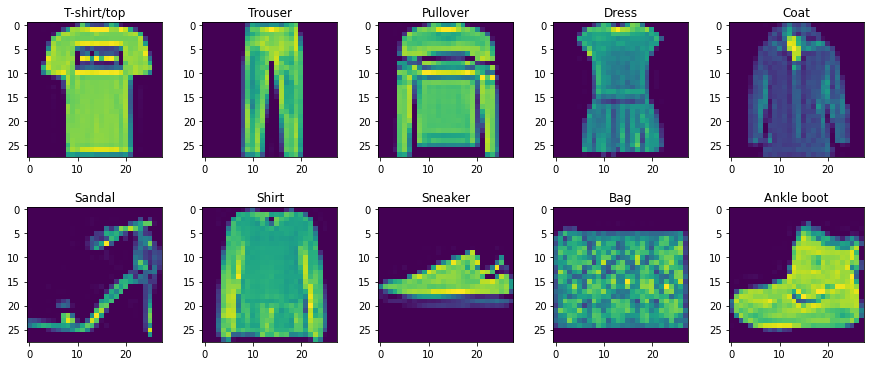

In [9]:
# Utility functions to preprocess image data and plotting

def flatten(arr):
    arr = arr.reshape(arr.shape[0], -1)
    return arr

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def plot_labels(data, labels, class_names, flatten=False):

    uniq_labels = np.unique(labels)

    fig, ax = plt.subplots(2,5, figsize=(15, 6))
    fig.subplots_adjust(wspace=0.3, hspace=0.3)
    ax = ax.reshape(-1)

    for i, label in enumerate(uniq_labels):

        img = data[np.where(labels == label)[0][0]]

        ax[i].set_title(class_names[label])
        
        if flatten:
            img = img.reshape(28, 28)

        ax[i].imshow(img)
    
    plt.show()

plot_labels(train_images, train_labels, class_names)

In [10]:
## Splitting the train labels itself into train and validation labels ##
train_images = flatten(train_images)
test_images = flatten(test_images)

train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.1, shuffle=True)
print(f"Train samples: {train_labels.shape[0]}, Validation samples: {val_labels.shape[0]}")

Train samples: 54000, Validation samples: 6000


In [11]:
## Creating an instance of the model ##
model = NeuralNet([FC(784, 64), RelU(), FC(64, 10)])
optimizer = Nadam()
loss = CrossEntropyLossFromLogits()

## Compiling the model with the loss and optimizer chosen ##
model.compile(loss, optimizer)

## Training the model (TEST RUN) ##
model.fit(train_images, train_labels, val_images, val_labels, batch_size=128, epochs=5)

## Evaluating the model on test data ##
model.evaluate(test_images, test_labels)

Epoch: 1 Train Loss: 0.5475901607260393 Train Accuracy: 0.8118784910291131 Val Loss: 0.42868370794162386 Val Accuracy: 0.8566916793313071
Epoch: 2 Train Loss: 0.4099594776286574 Train Accuracy: 0.8560029832430603 Val Loss: 0.38878533559122924 Val Accuracy: 0.8641954787234043
Epoch: 3 Train Loss: 0.3728922860048436 Train Accuracy: 0.8671822105619499 Val Loss: 0.36265964379518284 Val Accuracy: 0.8718180091185411
Epoch: 4 Train Loss: 0.347605096760473 Train Accuracy: 0.8764387271496276 Val Loss: 0.3496988131416274 Val Accuracy: 0.8769946808510638
Epoch: 5 Train Loss: 0.3294678987447292 Train Accuracy: 0.881402864759648 Val Loss: 0.3418448984434211 Val Accuracy: 0.8776833206686929

Model trained successfully!
Test loss: 0.37300020746117596 Test accuracy: 0.8658


In [12]:
def get_activation(name):
    if name == "relu":
        return RelU()
    elif name == "tanh":
        return Tanh()
    elif name == "sigmoid":
        return Sigmoid()

def get_optimizer(name, lr):
    if name == "sgd":
        return SGD(lr=lr)
    elif name == "momentum":
        return Momentum(lr=lr)
    elif name == "nag":
        return NAG(lr=lr)
    elif name == "rmsprop":
        return RMSprop(lr=lr)
    elif name == "adam":
        return Adam(lr=lr)
    elif name == "nadam":
        return Nadam(lr=lr)

def get_loss(name):
    if name == "cross_entropy":
        return CrossEntropyLossFromLogits()
    elif name == "mse":
        return MSELossFromLogits()

def create_layers(n_layers, layer_size, activation, weight_decay, init_method):

    layers = []
    layers.extend([FC(784,layer_size, weight_decay, init_method), get_activation(activation)])
    
    for _ in range(n_layers):
        layers.extend([FC(layer_size, layer_size, weight_decay, init_method), get_activation(activation)])
    
    layers.append(FC(layer_size, 10, weight_decay, init_method))

    return layers

### MNIST Dataset

In [13]:
# load mnist dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# scaling the images
x_train, x_test = x_train / 255.0, x_test / 255.0

# flatten images to vectors
x_train = flatten(x_train)
x_test = flatten(x_test)

print(f"Training samples: {len(x_train)} Test samples: {len(x_test)}")

Training samples: 60000 Test samples: 10000


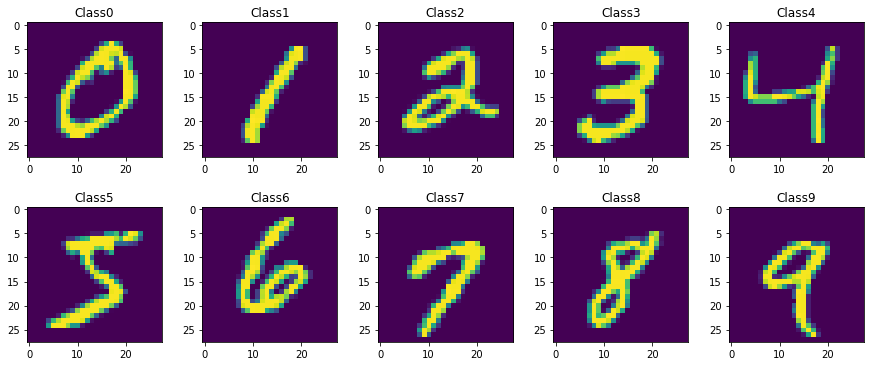

In [14]:
# plotting one image of each class
plot_labels(x_train, y_train, class_names=["Class"+str(i) for i in range(10)], flatten=True)

In [15]:
## 3 hyper-paramter configurations for MNIST ##

# Configuration 1

print("Configuration 1\n")
model1 = NeuralNet(create_layers(3, 128, "relu", 0, "xavier"))
model1.compile(loss=CrossEntropyLossFromLogits(), optimizer=Nadam())
model1.fit(x_train, y_train, x_test, y_test, batch_size=128, epochs=10)
model1.evaluate(x_test, y_test)

# Configuration 2

print("\nConfiguration 2\n")
model2 = NeuralNet(create_layers(4, 128, "relu", 0, "xavier"))
model2.compile(loss=CrossEntropyLossFromLogits(), optimizer=Nadam())
model2.fit(x_train, y_train, x_test, y_test, batch_size=128, epochs=10)
model2.evaluate(x_test, y_test)

# Configuration 3

print("\nConfiguration 3\n")
model3 = NeuralNet(create_layers(5, 128, "relu", 1e-3, "xavier"))
model3.compile(loss=CrossEntropyLossFromLogits(), optimizer=Nadam())
model3.fit(x_train, y_train, x_test, y_test, batch_size=128, epochs=10)
model3.evaluate(x_test, y_test)

Configuration 1

Epoch: 1 Train Loss: 0.2451462756620302 Train Accuracy: 0.9258784203980099 Val Loss: 0.16972643079315428 Val Accuracy: 0.9488726265822784
Epoch: 2 Train Loss: 0.10769609632283435 Train Accuracy: 0.9673618514570007 Val Loss: 0.12473100637089142 Val Accuracy: 0.9627175632911392
Epoch: 3 Train Loss: 0.07632527587652436 Train Accuracy: 0.9765902629708599 Val Loss: 0.12766294342835321 Val Accuracy: 0.9650909810126582
Epoch: 4 Train Loss: 0.05681080881555886 Train Accuracy: 0.9827369847192609 Val Loss: 0.10187808008798245 Val Accuracy: 0.9733979430379747
Epoch: 5 Train Loss: 0.04863459033474706 Train Accuracy: 0.9844027629708599 Val Loss: 0.1185031206037492 Val Accuracy: 0.9682555379746836
Epoch: 6 Train Loss: 0.04163021801882207 Train Accuracy: 0.9866848791755508 Val Loss: 0.14389013949095836 Val Accuracy: 0.9666732594936709
Epoch: 7 Train Loss: 0.03913261102291151 Train Accuracy: 0.9874844527363184 Val Loss: 0.11334843006938249 Val Accuracy: 0.9746835443037974
Epoch: 8 Tra

### Comparing the performance

In [16]:
# plotting the metrics for the model #

def compare_models_plot(models):
    
    n = len(models)
    model_names = ["model_" + str(i) for i in range(n)]
    
    colors = ["green", "blue", "red", "brown"]
    titles = ["Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy"]
    
    fig, axs = plt.subplots(2,2, figsize=(10,10))
    axs = axs.reshape(-1)
    
    for i in range(4):
        
        title = titles[i]
        axs[i].set_title(title)
        
        for j in range(n):
            axs[i].plot([d["Epoch"] for d in models[j].history], 
                            [d[title] for d in models[j].history], 
                            c=colors[j], 
                            label=model_names[j])
            
        axs[i].legend()
        
    plt.show()

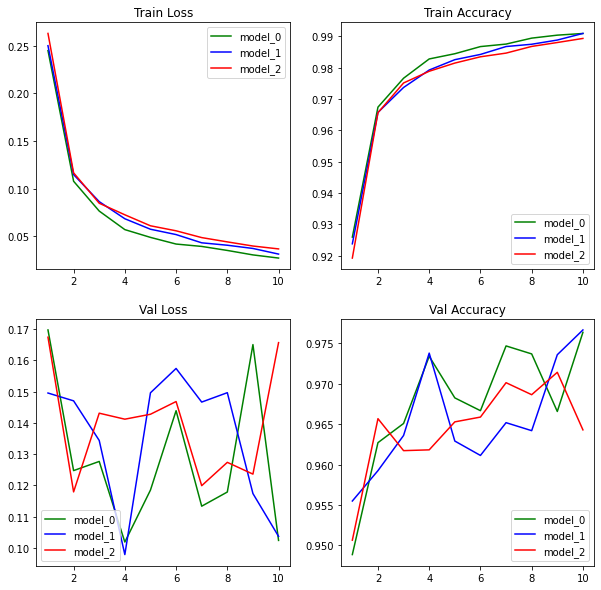

In [17]:
## Comparision of the configurations ##
compare_models_plot([model1, model2, model3])